In [31]:
import os 
!pip install -U -q segmentation-models --user
!pip install patchify
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [32]:
import os, cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

In [33]:
image_dir = "/kaggle/input/training/Training/input_resized"
mask_dir = "/kaggle/input/training/Training/mask_resized"


image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# large_image_stack = np.stack([cv2.imread(os.path.join(image_dir, file)) for file in image_files])
# large_mask_stack = np.stack([cv2.imread(os.path.join(mask_dir, file)) for file in mask_files])

large_image_stack = np.stack([cv2.cvtColor(cv2.imread(os.path.join(image_dir, file)), cv2.COLOR_BGR2GRAY) for file in image_files])
large_mask_stack = np.stack([cv2.cvtColor(cv2.imread(os.path.join(mask_dir, file)), cv2.COLOR_BGR2GRAY) for file in mask_files])

print(large_image_stack.shape)

(12, 1024, 768)


In [34]:
all_img_patches = []
for img in range(large_image_stack.shape[0]):
    print(img)     #just stop here to see all file names printed
     
    large_image = large_image_stack[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
                  
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 
images = np.stack((images,)*3, axis=-1)

0
1
2
3
4
5
6
7
8
9
10
11


In [35]:
all_mask_patches = []
for img in range(large_mask_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_mask = large_mask_stack[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

In [36]:
print(images.shape)
print(masks.shape)
print("Pixel values in the mask are: ", np.unique(masks))

(144, 256, 256, 3)
(144, 256, 256, 1)
Pixel values in the mask are:  [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.31372549 0.31764706 0.32156863 0.325

In [37]:
import tensorflow as tf
import keras
print(keras.__version__)

3.2.1


In [38]:
import segmentation_models as sm
print("Done")

Done


In [39]:
#Define the model
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
images1=preprocess_input1(images)
print(images1.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(144, 256, 256, 3)
(108, 256, 256, 3)
(36, 256, 256, 3)


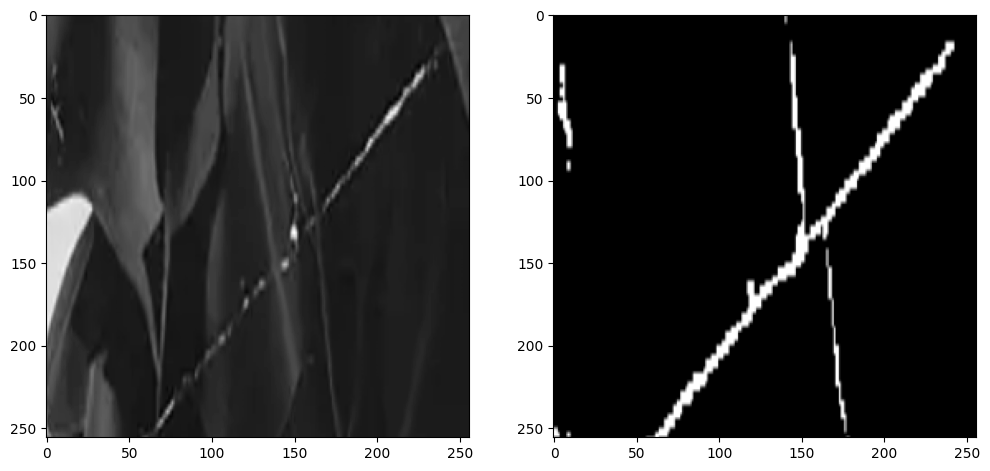

In [40]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [41]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

print("Block done")

Block done


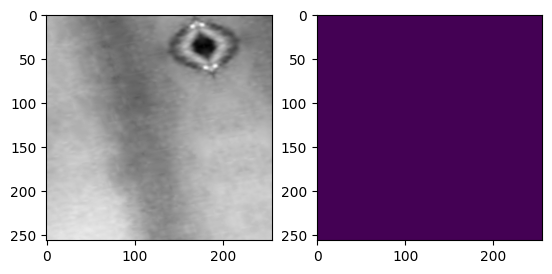

In [45]:
x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# print(model.summary())

In [46]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - iou_score: 0.2831 - loss: 0.9096 - val_iou_score: 0.0124 - val_loss: 1.3715
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 980ms/step - iou_score: 0.2771 - loss: 1.0217 - val_iou_score: 0.0065 - val_loss: 1.4375
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 897ms/step - iou_score: 0.1915 - loss: 1.2653 - val_iou_score: 0.0119 - val_loss: 1.3855
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 681ms/step - iou_score: 0.1142 - loss: 1.3519 - val_iou_score: 0.0321 - val_loss: 1.2977
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - iou_score: 0.0917 - loss: 1.2756 - val_iou_score: 0.0058 - val_loss: 1.4522
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - iou_score: 0.1000 - loss: 1.2180 - val_iou_score: 0.0184 - val_loss: 1.3437
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 740ms/step - iou_score: 0.0967 - loss: 1.2302 - val_iou_score: 0.0242 - val_loss: 1.3096
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 729ms/step - iou_score: 0.1216 - loss: 1.188

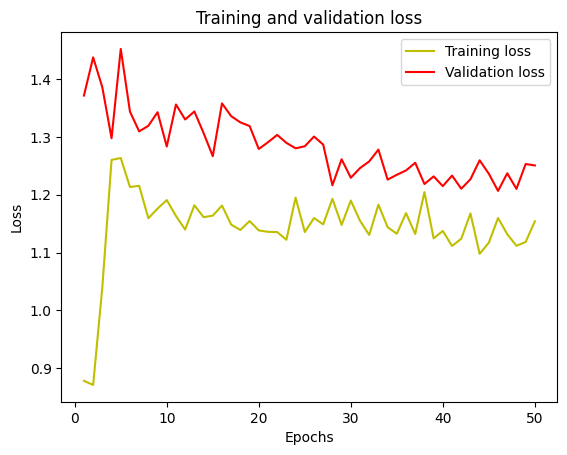

In [51]:
#Fit the model
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch= 20, validation_steps= 20, epochs=50)
# history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50)

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
model.save('my_model.h5')

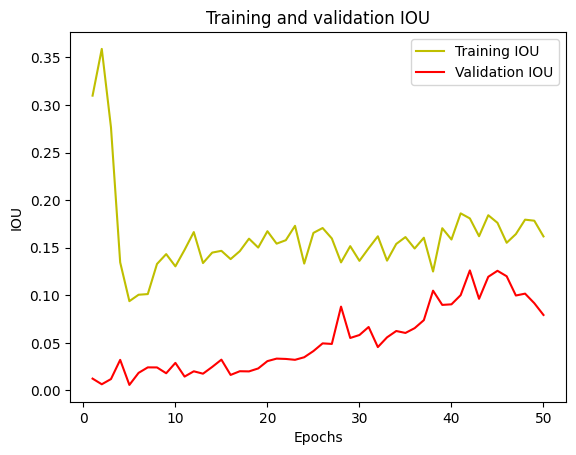

In [53]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
IoU socre is:  0.2807551957720781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


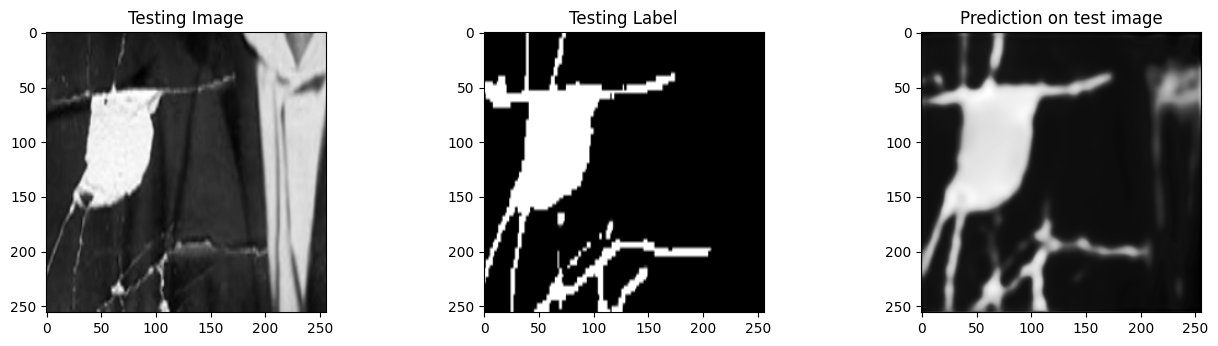

In [62]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()